In [1]:
import numpy as np
from numpy.random import default_rng
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process.kernels import RBF, Product, ConstantKernel, Kernel, Hyperparameter
from scipy.stats import loguniform

from sklearn.model_selection import RandomizedSearchCV

### Intro to Non-linear Regression

In [2]:
# Generates a RBF Gaussian kernel from training data X
def gaussian_kernel(X_1: np.ndarray, X_2: np.ndarray, gamma: int = 1):
    # note: np.outer computes the outer product between two vectors
    return np.exp(-gamma * (np.outer(X_1, np.ones_like(X_2)) - np.outer(np.ones_like(X_1), X_2)) ** 2)

# Generates a simple polynomial kernel from training data X
def polynomial_kernel(X_1: np.ndarray, X_2: np.ndarray, d: int, r: int = 1, gamma: int = 1):
    return (r + gamma * np.outer(X_1, X_2)) ** d

# Kernel ridge regression function
def kernel_ridge_regression(K: np.ndarray, y: np.ndarray, lambdas: np.ndarray):
    alphas = np.empty((K.shape[1], lambdas.shape[0]))
    fit = np.empty((y.shape[0], lambdas.shape[0]))
    mse = np.zeros((lambdas.shape[0]))

    lambda_min = lambdas[0]
    min_err = np.inf

    for i, lambd in enumerate(lambdas):
        alphas[:, i] = np.linalg.solve(K + lambd * np.eye(K.shape[0]), y)
        fit[:, i] = K @ alphas[:, i]
        mse[i] = np.mean((y - fit[:, i]) ** 2)

        if mse[i] < min_err:
            min_err = mse[i]
            lambda_min = lambdas[i]
    
    return {'fit': fit, 'alphas': alphas, 'mse': mse, 'lambda_min': lambda_min}

#### Polynomial kernel

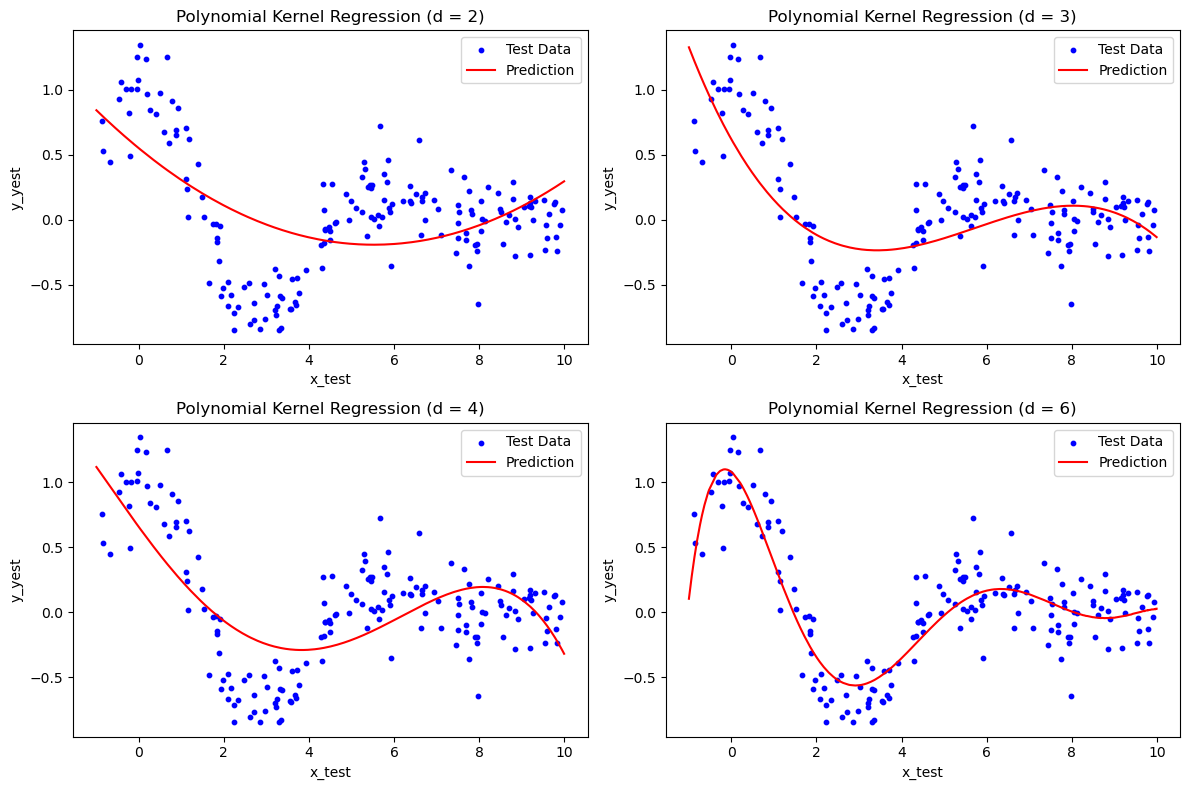

In [3]:
# Set a random seed for reproducibility
rng = default_rng(0)

# Generate data
n = 600
train_size = 0.7

x = np.sort(rng.uniform(low=-1, high=10, size=n))
y = np.exp(-(x/5) ** 2) * np.cos(x) + rng.normal(loc=0, scale=0.2, size=n)

lambda_grid = np.exp(1) ** np.linspace(10, -1, num=10)

# Split data into train and test
train_idx = np.sort(rng.choice(np.arange(x.shape[0]), size=int(x.shape[0] * train_size), replace=False))
test_idx = np.setdiff1d(np.arange(x.shape[0]), train_idx)

x_train = x[train_idx]
x_test = x[test_idx]
y_train = y[train_idx]
y_test = y[test_idx]

# Perform polynomial ridge regression
degrees = [2, 3, 4, 6]
train_mse = []
test_mse = []

plt.figure(figsize=(12, 8))
for i, degree in enumerate(degrees):
    kernel_output_train = polynomial_kernel(X_1=x_train, X_2=x_train, d=degree)
    reg = kernel_ridge_regression(K=kernel_output_train, y=y_train, lambdas=lambda_grid)
    lambda_min_idx = np.argmin(reg['mse'])

    kernel_output_test = polynomial_kernel(X_1=x_test, X_2=x_train, d=degree)
    y_pred_train = reg['fit'][:, lambda_min_idx]
    y_pred_test = kernel_output_test @ reg['alphas'][:, lambda_min_idx]

    train_mse.append(reg['mse'][lambda_min_idx])
    test_mse.append(np.mean((y_test - y_pred_test) ** 2))
    
    # Plot
    plt.subplot(2, 2, i + 1)
    plt.scatter(x_test, y_test, color='blue', label='Test Data', s=10)
    plt.plot(x_train, y_pred_train, color='red', label='Prediction')
    plt.title(f'Polynomial Kernel Regression (d = {degree})')
    plt.xlabel('x_test')
    plt.ylabel('y_yest')
    plt.legend()

plt.tight_layout()
plt.show()

poly_mse = {'degree': degrees, 'train_mse': train_mse, 'test_mse': test_mse}

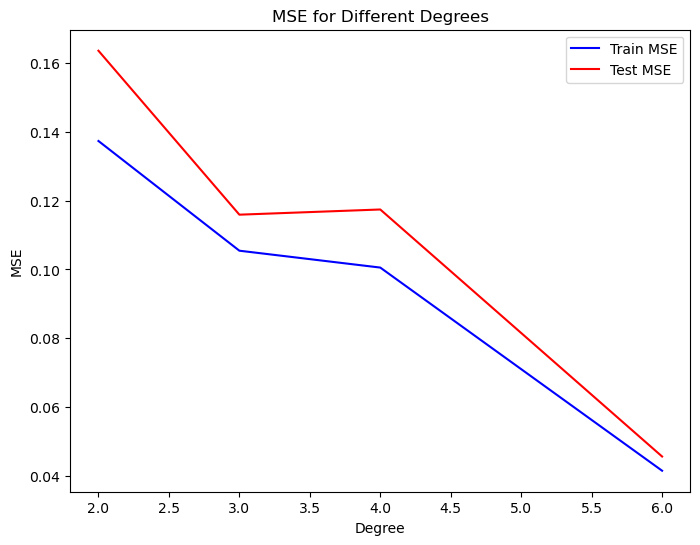

In [4]:
plt.figure(figsize=(8, 6))
plt.plot(poly_mse['degree'], poly_mse['train_mse'], linestyle='-', color='blue', label='Train MSE')
plt.plot(poly_mse['degree'], poly_mse['test_mse'], linestyle='-', color='red', label='Test MSE')

plt.xlabel('Degree')
plt.ylabel('MSE')
plt.title('MSE for Different Degrees')
plt.legend(loc='upper right')

plt.show()

#### RBF kernel

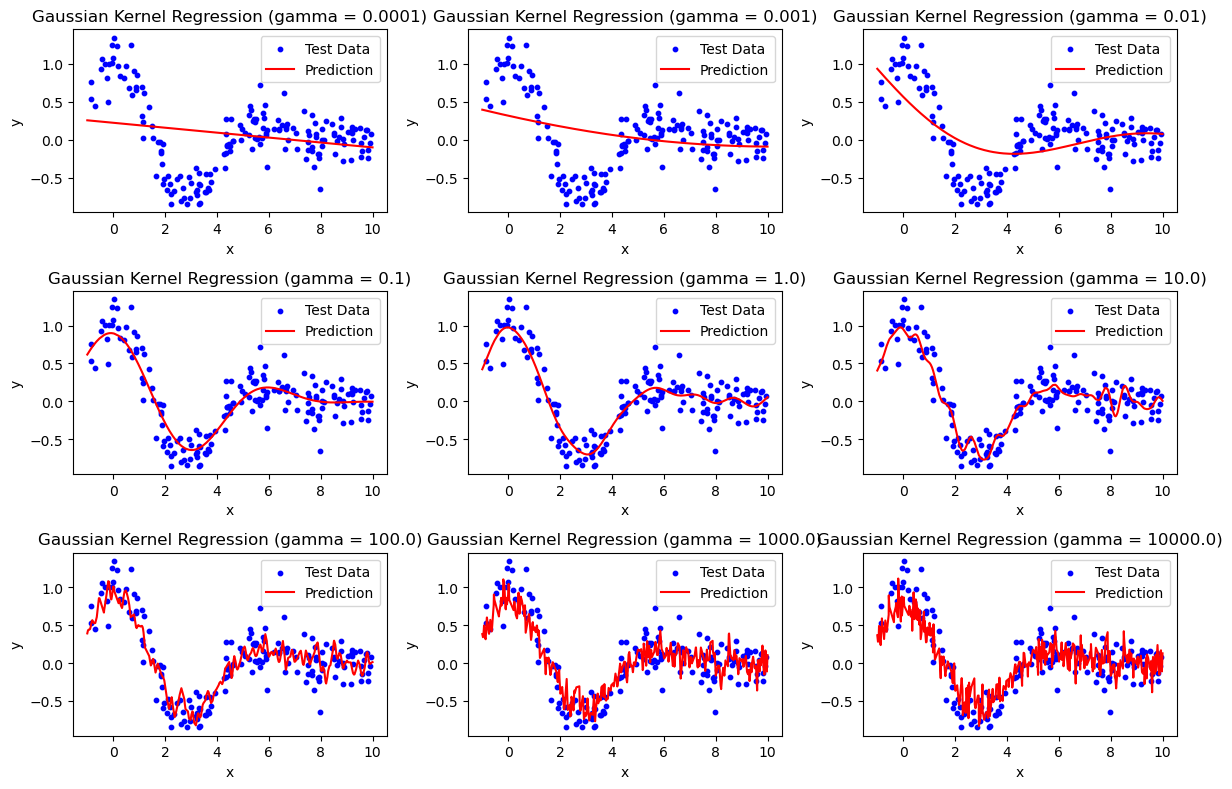

In [5]:
# Define gamma values
gammas = 10 ** np.arange(-4, 5, dtype=float)

train_mse = []
test_mse = []

# Perform Gaussian kernel ridge regression
plt.figure(figsize=(12, 8))
for i, g in enumerate(gammas):
    kernel_output_train = gaussian_kernel(X_1=x_train, X_2=x_train, gamma=g)
    reg = kernel_ridge_regression(kernel_output_train, y_train, lambda_grid)
    lambda_min_idx = np.argmin(reg['mse'])

    kernel_output_test = gaussian_kernel(X_1=x_test, X_2=x_train, gamma=g)
    y_pred_train = reg['fit'][:, lambda_min_idx]
    y_pred_test = kernel_output_test @ reg['alphas'][:, lambda_min_idx]

    train_mse.append(reg['mse'][lambda_min_idx])
    test_mse.append(np.mean((y_test - y_pred_test) ** 2))

    # Plot results
    plt.subplot(3, 3, i + 1)
    plt.scatter(x_test, y_test, color='blue', s=10, label='Test Data')
    plt.plot(x_train, y_pred_train, color='red', label='Prediction')
    plt.title(f'Gaussian Kernel Regression (gamma = {g})')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()

plt.tight_layout()
plt.show()

# Store results
rbf_mse = {'gamma': gammas, 'train_mse': train_mse, 'test_mse': test_mse}


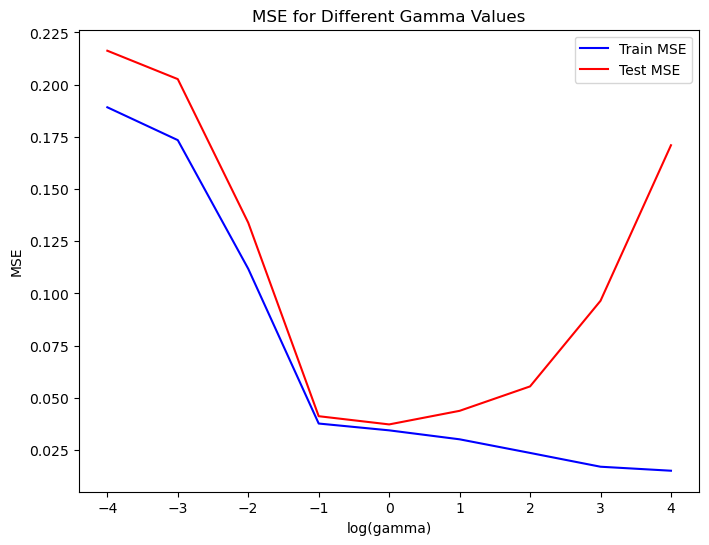

In [6]:
# Plot the train and test MSE for each gamma
plt.figure(figsize=(8, 6))
plt.plot(np.log10(rbf_mse['gamma']), rbf_mse['train_mse'], linestyle='-', color='blue', label='Train MSE')
plt.plot(np.log10(rbf_mse['gamma']), rbf_mse['test_mse'], linestyle='-', color='red', label='Test MSE')

plt.xlabel('log(gamma)')
plt.ylabel('MSE')
plt.title('MSE for Different Gamma Values')
plt.legend(loc='upper right')

plt.show()


### Introduction to Gaussian Process Regression

Previously, we explored kernel ridge regression using polynomial and RBF kernels. From a Bayesian perspective, these can be seen as maximum a posteriori (MAP) estimates of the regression line. Intuitively, a MAP estimate provides a single best-fit solution. In this notebook, we introduce Gaussian Process (GP) regression, which performs full Bayesian inference to estimate the entire posterior distribution of the regression line. This approach not only models the regression line but also allows us to quantify the uncertainty of our predictions.

In [7]:
# kernel ridge regression function using sklearn
def kernel_ridge_regression(X_train: np.ndarray, 
                            y_train: np.ndarray,
                            X_test: np.ndarray,
                            kernel_function):
    kernel_ridge = KernelRidge(kernel=RBF())

    param_distributions = {
        'alpha': loguniform(1e0, 1e3),
        'kernel__length_scale': loguniform(1e-2, 1e2)
    }
    kernel_ridge_tuned = RandomizedSearchCV(
        kernel_ridge,
        param_distributions=param_distributions,
        n_iter=500,
        random_state=0
    )

    kernel_ridge_tuned.fit(X_train.reshape(-1, 1), y_train)
    
    return kernel_ridge_tuned.predict(X_test.reshape(-1, 1)), kernel_ridge_tuned.predict(X_train.reshape(-1, 1))


# GP regression function
def gp_regression(X_train: np.ndarray, 
                  y_train: np.ndarray,
                  X_test: np.ndarray,
                  kernel_function):

    gaussian_process = GaussianProcessRegressor(kernel=kernel_function(), alpha=1e-0)
    gaussian_process.fit(X_train.reshape(-1, 1), y_train)

    return gaussian_process.predict(X_test.reshape(-1, 1), return_std=True), gaussian_process.predict(X_train.reshape(-1, 1), return_std=True)

#### Generate data and compare methods

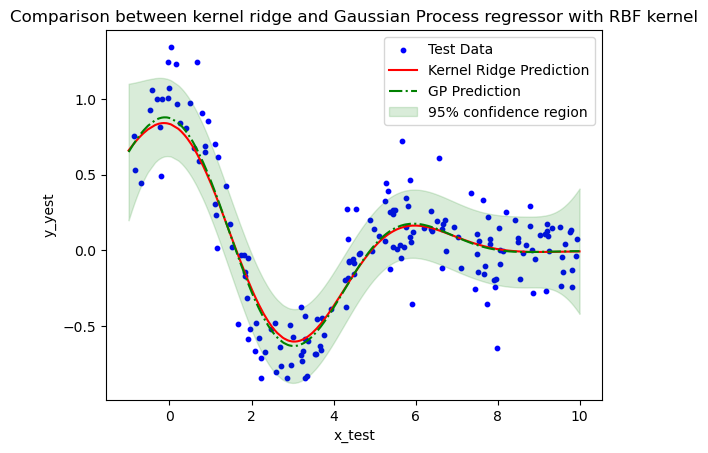

Kernel Ridge MSE: 0.0448, GP MSE: 0.0422


In [8]:
# Set a random seed for reproducibility
rng = default_rng(0)

# Generate data
n = 600
train_size = 0.7

x = np.sort(rng.uniform(low=-1, high=10, size=n))
y = np.exp(-(x/5) ** 2) * np.cos(x) + rng.normal(loc=0, scale=0.2, size=n)

# Split data into train and test
train_idx = np.sort(rng.choice(np.arange(x.shape[0]), size=int(x.shape[0] * train_size), replace=False))
test_idx = np.setdiff1d(np.arange(x.shape[0]), train_idx)

x_train = x[train_idx]
x_test = x[test_idx]
y_train = y[train_idx]
y_test = y[test_idx]

kernel_y_pred_test, kernel_y_pred_train = kernel_ridge_regression(x_train, y_train, x_test, kernel_function=RBF)
(mu_test, sigma_test), (mu_train, sigma_train) = gp_regression(x_train, y_train, x_test, kernel_function=RBF)

plt.scatter(x_test, y_test, color='blue', label='Test Data', s=10)
plt.plot(x_train, kernel_y_pred_train, color='red', label='Kernel Ridge Prediction')
plt.plot(x_train, mu_train, color='green', linestyle='dashdot', label='GP Prediction')
plt.fill_between(x=x_train,
                y1=mu_train - 2 * sigma_train,
                y2=mu_train + 2 * sigma_train,
                color='green',
                alpha=0.15,
                label='95% confidence region')
plt.title(f'Comparison between kernel ridge and Gaussian Process regressor with RBF kernel')
plt.xlabel('x_test')
plt.ylabel('y_yest')
plt.legend()

plt.show()

print(f'Kernel Ridge MSE: {np.mean((y_test - kernel_y_pred_test) ** 2):.4f}, GP MSE: {np.mean((y_test - mu_test) ** 2):.4f}')


#### Polynomial kernel

In [9]:
# Custom Polynomial Kernel for sklearn GPRegressor class
class PolynomialKernel(Kernel):
    def __init__(self, d: int = 6, r: int = 1, gamma: int = 1):
        self.d = d
        self.r = r
        self.gamma = gamma

    def __call__(self, X, Y=None):
        if Y is None:
            Y = X
        return (self.r + self.gamma * np.dot(X, Y.T)) ** self.d

    def diag(self, X):
        # Compute the diagonal of the kernel matrix
        return (self.r + self.gamma * np.sum(X**2, axis=1)) ** self.d
    
    def is_stationary(self):
        return False

    def __repr__(self):
        return f"PolynomialKernel(d={self.d}, r={self.r}, gamma={self.gamma})"

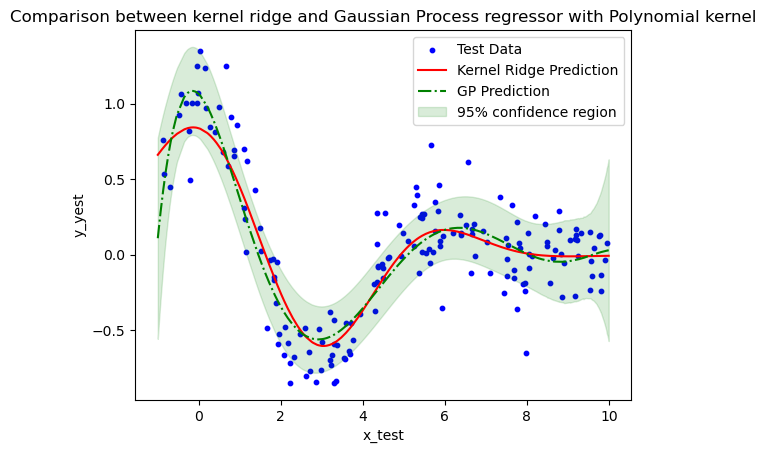

Kernel Ridge MSE: 0.0448, GP MSE: 0.0460


In [10]:
kernel_y_pred_test, kernel_y_pred_train = kernel_ridge_regression(x_train, y_train, x_test, kernel_function=PolynomialKernel)
(mu_test, sigma_test), (mu_train, sigma_train) = gp_regression(x_train, y_train, x_test, kernel_function=PolynomialKernel)

plt.scatter(x_test, y_test, color='blue', label='Test Data', s=10)
plt.plot(x_train, kernel_y_pred_train, color='red', label='Kernel Ridge Prediction')
plt.plot(x_train, mu_train, color='green', linestyle='dashdot', label='GP Prediction')
plt.fill_between(x=x_train,
                y1=mu_train - 2 * sigma_train,
                y2=mu_train + 2 * sigma_train,
                color='green',
                alpha=0.15,
                label='95% confidence region')
plt.title(f'Comparison between kernel ridge and Gaussian Process regressor with Polynomial kernel')
plt.xlabel('x_test')
plt.ylabel('y_yest')
plt.legend()

plt.show()

print(f'Kernel Ridge MSE: {np.mean((y_test - kernel_y_pred_test) ** 2):.4f}, GP MSE: {np.mean((y_test - mu_test) ** 2):.4f}')